In [34]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### data load

In [36]:
# 파일 호출
data_path: str = "../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [37]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:02<00:00, 36.44it/s]


### data engineering

In [38]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_liquidations_okex_btc_usdt_long_liquidations                 100.0
hourly_market-data_liquidations_okex_btc_usdt_short_liquidations                100.0
hourly_market-data_liquidations_okex_btc_usdt_long_liquidations_usd             100.0
hourly_market-data_open-interest_kraken_open_interest                           100.0
hourly_market-data_liquidations_ftx_all_symbol_long_liquidations                100.0
                                                                                ...  
hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations          0.0
hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd       0.0
hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd      0.0
target                                                                            0.0
ID                                                                                0.0
Length: 255, dtype: float64

In [39]:
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()

# 결측치 ffill 사용
new_df = df[non_missing_columns[:-2]].fillna(method='ffill')
new_df2 = pd.concat([df[['ID','target']],new_df], axis=1)
new_df2

,ID,target,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2023-01-01 00:00:00,2.0,3.180371e+08,0.0,0.0,0.0,0.0,0.01,2015805.0,1411658.0,...,197.51610,0.00000,3.412540e+07,37752,0.561037,9271.503609,0.000,0.00,0.0000,0.0000
1,2023-01-01 01:00:00,1.0,3.183281e+08,0.0,0.0,0.0,0.0,0.01,4032601.0,1174054.0,...,0.00000,11833.56104,3.456750e+07,20534,0.256248,4237.095391,0.000,0.00,0.0000,0.0000
2,2023-01-01 02:00:00,1.0,3.179729e+08,0.0,0.0,0.0,0.0,0.01,857595.0,1494750.0,...,0.00000,0.00000,3.452090e+07,19369,0.312978,5176.614029,0.000,0.00,0.0000,0.0000
3,2023-01-01 03:00:00,1.0,3.179643e+08,0.0,0.0,0.0,0.0,0.01,1237990.0,869405.0,...,9754.76891,0.00000,3.438940e+07,23799,0.219829,3632.186132,0.000,0.00,0.0000,0.0000
4,2023-01-01 04:00:00,2.0,3.174773e+08,0.0,0.0,0.0,0.0,0.01,2423293.0,2816626.0,...,5944.43714,0.00000,3.439200e+07,31712,0.344866,5699.177070,0.000,0.00,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2024-04-26 03:00:00,NaN,2.543361e+07,0.0,0.0,0.0,0.0,0.01,2287006.0,2581811.0,...,36502.94223,0.00000,4.281260e+07,13601,2.339916,150728.680308,1.505,0.18,95847.7566,11578.1918
11548,2024-04-26 04:00:00,NaN,2.543361e+07,0.0,0.0,0.0,0.0,0.01,4852344.0,7870643.0,...,273829.68959,2582.91040,4.275070e+07,29096,4.045398,260219.961065,1.505,0.18,95847.7566,11578.1918
11549,2024-04-26 05:00:00,NaN,2.543361e+07,0.0,0.0,0.0,0.0,0.01,8300391.0,8684026.0,...,13683.81333,43172.43989,4.277180e+07,22094,3.752089,241282.824002,1.505,0.18,95847.7566,11578.1918
11550,2024-04-26 06:00:00,NaN,2.543361e+07,0.0,0.0,0.0,0.0,0.01,3773806.0,3425631.0,...,33730.60191,1230.34824,4.266640e+07,12668,1.941932,125150.157841,1.505,0.18,95847.7566,11578.1918


In [40]:
# 상관계수 대각행렬 값 확인

numeric_df = new_df2.loc[new_df2["_type"]=="train"].iloc[:,2:].select_dtypes(include=[float, int])
corr_matrix = numeric_df.corr()

corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_pairs = corr_matrix.stack()
corr_pairs = corr_pairs.abs().sort_values(ascending=False)

In [41]:
# 상관계수 임계값
threshold = 0.9

# 상관계수가 threshold 이상인 쌍 추출
high_corr_pairs = corr_pairs[corr_pairs > threshold]

# 변수 중복 제거를 위한 세트
to_remove = set()

# 높은 상관관계를 가진 변수 쌍 중 하나만 남기기
for col1, col2 in high_corr_pairs.index:
    if col1 not in to_remove and col2 not in to_remove:
        to_remove.add(col2)  # col2를 제거 목록에 추가 (col1은 남김)

# 결과 데이터프레임 생성
removed_vars = list(to_remove)

### train_val_split

In [42]:
final_df = new_df2.drop(columns = removed_vars)

# _type에 따라 train, test 분리
train_df = final_df.loc[final_df["_type"]=="train"].drop(columns=["_type"])
test_df = final_df.loc[final_df["_type"]=="test"].drop(columns=["_type"])

In [43]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [44]:
# 5개의 교차검증 실시
btscv = BlockingTimeSeriesSplit(n_splits=5)

X = train_df.iloc[:,2:]
y = train_df['target']

### training

In [45]:
# 성능 평가를 위한 변수 초기화
all_valid_scores = []

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    # lgb dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # lgb params
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": 50,
        "learning_rate": 0.05,
        "n_estimators": 30,
        "random_state": 42,
        "verbose": 0,
    }

    # lgb train
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )

    # lgb predict
    y_valid_pred = lgb_model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)

    # score check
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")
    
    all_valid_scores.append((accuracy, auroc))
    
    print(f"Fold {fold + 1}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}\n")

# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1
Accuracy: 0.4558
AUROC: 0.5965

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 2
Accuracy: 0.4644
AUROC: 0.5456

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3
Accuracy: 0.4103
AUROC: 0.5518

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4
Accuracy: 0.4359
AUROC: 0.6144

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 5
Accuracy: 0.

In [46]:
# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

Average Accuracy: 0.4462
Average AUROC: 0.5798


In [47]:
feature_importances = final_lgb_model.feature_importance(importance_type='split')
feature_names = X.columns
# 피처 중요도 데이터프레임 생성
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 중요도에 따라 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
33,hourly_market-data_open-interest_bitfinex_all_...,220
28,hourly_market-data_open-interest_huobi_global_...,161
21,hourly_market-data_taker-buy-sell-stats_deribi...,152
60,hourly_market-data_taker-buy-sell-stats_bitmex...,140
83,hourly_network-data_tokens-transferred_tokens_...,125
...,...,...
63,hourly_market-data_liquidations_bitfinex_btc_u...,9
66,hourly_market-data_liquidations_bitmex_all_sym...,9
16,hourly_market-data_liquidations_deribit_all_sy...,5
24,hourly_market-data_taker-buy-sell-stats_deribi...,4


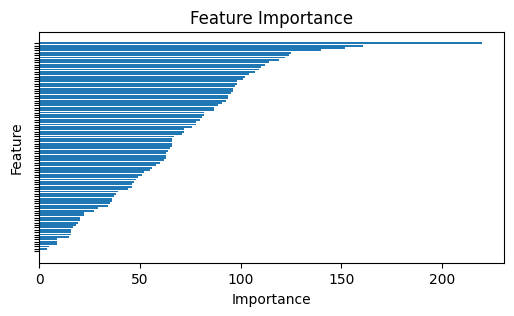

In [48]:
plt.figure(figsize=(6, 3))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.yticks(range(len(importance_df)), [''] * len(importance_df))  # 축 항목 제거
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 상위 중요도 피처가 위에 오도록
plt.show()

### inference

In [49]:
# lgb predict
y_test_pred = final_lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

### feature importance를 기반으로 변수를 제거한 뒤 재학습 실행

#### split

In [50]:
filtered_columns = list(importance_df[importance_df['Importance'] > 50]['Feature'])

In [51]:
# _type에 따라 train, test 분리
X = train_df[filtered_columns]
test_df = test_df[['ID','target'] + filtered_columns]

#### modeling

In [52]:
# 성능 평가를 위한 변수 초기화
all_valid_scores = []

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    # lgb dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # lgb params
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": 50,
        "learning_rate": 0.05,
        "n_estimators": 30,
        "random_state": 42,
        "verbose": 0,
    }

    # lgb train
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )

    # lgb predict
    y_valid_pred = lgb_model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)

    # score check
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")
    
    all_valid_scores.append((accuracy, auroc))
    
    print(f"Fold {fold + 1}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}\n")

# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1
Accuracy: 0.4473
AUROC: 0.5761

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 2
Accuracy: 0.4872
AUROC: 0.5636

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3
Accuracy: 0.4274
AUROC: 0.5142

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4
Accuracy: 0.4615
AUROC: 0.6001

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 5
Accuracy: 0.

In [53]:
# 성능 지표 평균 계산
avg_accuracy = np.mean([score[0] for score in all_valid_scores])
avg_auroc = np.mean([score[1] for score in all_valid_scores])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")

# 전체 데이터로 최종 모델 학습
train_data = lgb.Dataset(X, label=y)
final_lgb_model = lgb.train(
    params=params,
    train_set=train_data
)

Average Accuracy: 0.4570
Average AUROC: 0.5717


#### optuna 활용

In [54]:
btscv = BlockingTimeSeriesSplit(n_splits=1)

# 교차 검증 수행
for fold, (train_index, test_index) in enumerate(btscv.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

In [55]:
import optuna

def objective(trial):
    # 하이퍼파라미터 검색 공간 정의
    params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "random_state": 42
    }
    
    # LightGBM 데이터셋 생성
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    # 모델 학습
    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )
    
    # 예측 및 평가
    y_valid_pred = model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    
    return accuracy

# Optuna study 생성 및 최적화 수행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2024-09-22 14:17:47,975] A new study created in memory with name: no-name-032bfc68-8109-4724-94b9-b3119373398c


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:17:48,333] Trial 0 finished with value: 0.4360730593607306 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'learning_rate': 0.022110103707694617, 'n_estimators': 33, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.9104381392144828, 'colsample_bytree': 0.5092731182104493}. Best is trial 0 with value: 0.4360730593607306.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:17:49,228] Trial 1 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'learning_rate': 0.004416702768524717, 'n_estimators': 33, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.5835306998212666, 'colsample_bytree': 0.7273006730189036}. Best is trial 1 with value: 0.4497716894977169.
[I 2024-09-22 14:17:49,404] Trial 2 finished with value: 0.4486301369863014 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'learning_rate': 0.003389617192160785, 'n_estimators': 45, 'max_depth': 3, 'min_child_samples': 38, 'subsample': 0.733118905021466, 'colsample_bytree': 0.9280547819096268}. Best is trial 1 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score 

[I 2024-09-22 14:17:49,560] Trial 3 finished with value: 0.4440639269406393 and parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'learning_rate': 0.017143383792440525, 'n_estimators': 39, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.5112761818832117, 'colsample_bytree': 0.9550492204620923}. Best is trial 1 with value: 0.4497716894977169.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training fro

[I 2024-09-22 14:17:49,907] Trial 4 finished with value: 0.3875570776255708 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'learning_rate': 0.07198368361180756, 'n_estimators': 45, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.8414648876773186, 'colsample_bytree': 0.9476455224639141}. Best is trial 1 with value: 0.4497716894977169.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 14:17:51,327] Trial 5 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'learning_rate': 0.011007327269714613, 'n_estimators': 79, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.562869381788514, 'colsample_bytree': 0.9731752572990063}. Best is trial 1 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:17:52,333] Trial 6 finished with value: 0.4309360730593607 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'learning_rate': 0.043341444878068895, 'n_estimators': 75, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.7554025825902182, 'colsample_bytree': 0.700568568858632}. Best is trial 1 with value: 0.4497716894977169.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:17:53,377] Trial 7 finished with value: 0.4526255707762557 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'learning_rate': 0.003671784367213653, 'n_estimators': 58, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.6850869370535184, 'colsample_bytree': 0.7572584185073166}. Best is trial 7 with value: 0.4526255707762557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:17:53,656] Trial 8 finished with value: 0.4434931506849315 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.017969206896516692, 'n_estimators': 25, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.9689609364861089, 'colsample_bytree': 0.8429041418167917}. Best is trial 7 with value: 0.4526255707762557.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:17:53,918] Trial 9 finished with value: 0.4469178082191781 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'learning_rate': 0.003924321453434749, 'n_estimators': 28, 'max_depth': 9, 'min_child_samples': 44, 'subsample': 0.6736929130654652, 'colsample_bytree': 0.9275764621508497}. Best is trial 7 with value: 0.4526255707762557.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 14:17:54,805] Trial 10 finished with value: 0.4509132420091324 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'learning_rate': 0.0010776245425217499, 'n_estimators': 99, 'max_depth': 6, 'min_child_samples': 32, 'subsample': 0.6601464472803288, 'colsample_bytree': 0.6132693039451139}. Best is trial 7 with value: 0.4526255707762557.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 14:17:55,668] Trial 11 finished with value: 0.4474885844748858 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'learning_rate': 0.0010095297735836335, 'n_estimators': 94, 'max_depth': 6, 'min_child_samples': 33, 'subsample': 0.6730668269077861, 'colsample_bytree': 0.6261124119283634}. Best is trial 7 with value: 0.4526255707762557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 14:17:56,704] Trial 12 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'learning_rate': 0.001327126098969372, 'n_estimators': 60, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.6382745612658964, 'colsample_bytree': 0.5987238904974665}. Best is trial 7 with value: 0.4526255707762557.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 14:17:57,468] Trial 13 finished with value: 0.4549086757990868 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'learning_rate': 0.0020520157087397803, 'n_estimators': 62, 'max_depth': 12, 'min_child_samples': 50, 'subsample': 0.7849305264488451, 'colsample_bytree': 0.7971157965535609}. Best is trial 13 with value: 0.4549086757990868.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:17:58,131] Trial 14 finished with value: 0.4509132420091324 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'learning_rate': 0.002218605368960703, 'n_estimators': 60, 'max_depth': 12, 'min_child_samples': 49, 'subsample': 0.7864807080580886, 'colsample_bytree': 0.8155602517034353}. Best is trial 13 with value: 0.4549086757990868.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:17:58,859] Trial 15 finished with value: 0.4457762557077626 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'learning_rate': 0.008517917243974589, 'n_estimators': 61, 'max_depth': 12, 'min_child_samples': 43, 'subsample': 0.8212562757610649, 'colsample_bytree': 0.8079490812973957}. Best is trial 13 with value: 0.4549086757990868.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:17:59,541] Trial 16 finished with value: 0.4520547945205479 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'learning_rate': 0.0021131238749977654, 'n_estimators': 70, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.8847555304998654, 'colsample_bytree': 0.7580978823292776}. Best is trial 13 with value: 0.4549086757990868.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 14:17:59,840] Trial 17 finished with value: 0.4440639269406393 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'learning_rate': 0.0060210221313776145, 'n_estimators': 52, 'max_depth': 4, 'min_child_samples': 50, 'subsample': 0.7220562128778432, 'colsample_bytree': 0.8618054102856156}. Best is trial 13 with value: 0.4549086757990868.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 14:18:02,114] Trial 18 finished with value: 0.4503424657534247 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'learning_rate': 0.0025389166569437733, 'n_estimators': 84, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.6074166761598185, 'colsample_bytree': 0.6609832195858961}. Best is trial 13 with value: 0.4549086757990868.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 14:18:02,603] Trial 19 finished with value: 0.4463470319634703 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'learning_rate': 0.0017305847444090234, 'n_estimators': 66, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.7922648970127547, 'colsample_bytree': 0.7876531110237358}. Best is trial 13 with value: 0.4549086757990868.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-22 14:18:03,246] Trial 20 finished with value: 0.4526255707762557 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'learning_rate': 0.008399937145805187, 'n_estimators': 52, 'max_depth': 8, 'min_child_samples': 40, 'subsample': 0.9997468520189725, 'colsample_bytree': 0.867400226604885}. Best is trial 13 with value: 0.4549086757990868.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:04,350] Trial 21 finished with value: 0.4560502283105023 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'learning_rate': 0.006417941467682986, 'n_estimators': 52, 'max_depth': 8, 'min_child_samples': 41, 'subsample': 0.9511135604038451, 'colsample_bytree': 0.8650482013644079}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 14:18:04,957] Trial 22 finished with value: 0.4469178082191781 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'learning_rate': 0.005288302989373914, 'n_estimators': 54, 'max_depth': 7, 'min_child_samples': 47, 'subsample': 0.9212835696968347, 'colsample_bytree': 0.7612800464183928}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 14:18:05,544] Trial 23 finished with value: 0.442351598173516 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'learning_rate': 0.0030256450484186116, 'n_estimators': 46, 'max_depth': 11, 'min_child_samples': 39, 'subsample': 0.857558771349523, 'colsample_bytree': 0.8911623577455745}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 14:18:06,011] Trial 24 finished with value: 0.4474885844748858 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'learning_rate': 0.005755206549302875, 'n_estimators': 68, 'max_depth': 5, 'min_child_samples': 44, 'subsample': 0.7123641976674371, 'colsample_bytree': 0.6935116637486936}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 14:18:07,094] Trial 25 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'learning_rate': 0.0017268402391321614, 'n_estimators': 86, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.9642114318612452, 'colsample_bytree': 0.8953312867820611}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:08,155] Trial 26 finished with value: 0.444634703196347 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'learning_rate': 0.011990478593291751, 'n_estimators': 54, 'max_depth': 10, 'min_child_samples': 36, 'subsample': 0.7683831194410347, 'colsample_bytree': 0.7788950954278657}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 14:18:08,974] Trial 27 finished with value: 0.4503424657534247 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'learning_rate': 0.006825190098367012, 'n_estimators': 64, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.7055186542556522, 'colsample_bytree': 0.8263852541710669}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 14:18:09,535] Trial 28 finished with value: 0.4480593607305936 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.003359633810711189, 'n_estimators': 73, 'max_depth': 11, 'min_child_samples': 41, 'subsample': 0.8140135441698539, 'colsample_bytree': 0.7220406877624347}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:10,012] Trial 29 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'learning_rate': 0.03379699763048379, 'n_estimators': 38, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.9132538502084665, 'colsample_bytree': 0.505601273388109}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 14:18:10,418] Trial 30 finished with value: 0.4394977168949772 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'learning_rate': 0.013714202341433324, 'n_estimators': 56, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.8687958797968756, 'colsample_bytree': 0.57069069773412}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 14:18:11,971] Trial 31 finished with value: 0.4503424657534247 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'learning_rate': 0.007752166670217261, 'n_estimators': 50, 'max_depth': 8, 'min_child_samples': 40, 'subsample': 0.9862667416975456, 'colsample_bytree': 0.8797880850717896}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:12,506] Trial 32 finished with value: 0.4400684931506849 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'learning_rate': 0.00428096945238315, 'n_estimators': 38, 'max_depth': 8, 'min_child_samples': 36, 'subsample': 0.939720995523055, 'colsample_bytree': 0.9942566734156882}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-09-22 14:18:13,060] Trial 33 finished with value: 0.4497716894977169 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'learning_rate': 0.008856443362103323, 'n_estimators': 48, 'max_depth': 7, 'min_child_samples': 47, 'subsample': 0.9513948050184806, 'colsample_bytree': 0.8518028419770423}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-22 14:18:13,668] Trial 34 finished with value: 0.4514840182648402 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'learning_rate': 0.0029198075826793127, 'n_estimators': 41, 'max_depth': 10, 'min_child_samples': 38, 'subsample': 0.9943983367849918, 'colsample_bytree': 0.7309162101246816}. Best is trial 21 with value: 0.4560502283105023.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:14,134] Trial 35 finished with value: 0.4600456621004566 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'learning_rate': 0.004840392396356941, 'n_estimators': 32, 'max_depth': 9, 'min_child_samples': 42, 'subsample': 0.8903551430018523, 'colsample_bytree': 0.7930306547683877}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:14,536] Trial 36 finished with value: 0.4520547945205479 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'learning_rate': 0.004775830060801231, 'n_estimators': 27, 'max_depth': 9, 'min_child_samples': 50, 'subsample': 0.8924116451888385, 'colsample_bytree': 0.7869322410616331}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:15,097] Trial 37 finished with value: 0.4412100456621005 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'learning_rate': 0.0017331891769831454, 'n_estimators': 31, 'max_depth': 12, 'min_child_samples': 42, 'subsample': 0.8437448509250276, 'colsample_bytree': 0.9099402386838938}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:15,796] Trial 38 finished with value: 0.454337899543379 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'learning_rate': 0.0038243941297767506, 'n_estimators': 20, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.7471401139401258, 'colsample_bytree': 0.7393176617465105}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:16,214] Trial 39 finished with value: 0.4514840182648402 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'learning_rate': 0.024848987538496833, 'n_estimators': 34, 'max_depth': 10, 'min_child_samples': 46, 'subsample': 0.7399289128692768, 'colsample_bytree': 0.6746617108973676}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:16,555] Trial 40 finished with value: 0.4292237442922374 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.09430909400087198, 'n_estimators': 24, 'max_depth': 9, 'min_child_samples': 48, 'subsample': 0.5238655295755253, 'colsample_bytree': 0.7227743184192489}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:16,844] Trial 41 finished with value: 0.4554794520547945 and parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'learning_rate': 0.0038331124366001905, 'n_estimators': 20, 'max_depth': 9, 'min_child_samples': 45, 'subsample': 0.7592107104525317, 'colsample_bytree': 0.7459891437530728}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:17,243] Trial 42 finished with value: 0.4503424657534247 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'learning_rate': 0.0041361726750034754, 'n_estimators': 20, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.7681514908975933, 'colsample_bytree': 0.8160216108928164}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:17,519] Trial 43 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'learning_rate': 0.0025715780890552126, 'n_estimators': 21, 'max_depth': 9, 'min_child_samples': 43, 'subsample': 0.8171067309379052, 'colsample_bytree': 0.7345608123396379}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:17,920] Trial 44 finished with value: 0.4509132420091324 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'learning_rate': 0.006676440546038752, 'n_estimators': 31, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.7924902878859839, 'colsample_bytree': 0.8394282354033775}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:18,247] Trial 45 finished with value: 0.4480593607305936 and parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'learning_rate': 0.0036357299291262077, 'n_estimators': 22, 'max_depth': 9, 'min_child_samples': 48, 'subsample': 0.7594442614042062, 'colsample_bytree': 0.7830878076763514}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:18,711] Trial 46 finished with value: 0.4480593607305936 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'learning_rate': 0.0013298564558283075, 'n_estimators': 42, 'max_depth': 8, 'min_child_samples': 42, 'subsample': 0.6924683733267294, 'colsample_bytree': 0.7076898464147672}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:19,593] Trial 47 finished with value: 0.4509132420091324 and parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'learning_rate': 0.004586961690496287, 'n_estimators': 34, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.7387013414806336, 'colsample_bytree': 0.8001253338749837}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-22 14:18:19,978] Trial 48 finished with value: 0.4509132420091324 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'learning_rate': 0.0024982717029348356, 'n_estimators': 28, 'max_depth': 9, 'min_child_samples': 50, 'subsample': 0.63836626853677, 'colsample_bytree': 0.7557096340430858}. Best is trial 35 with value: 0.4600456621004566.
[I 2024-09-22 14:18:20,244] Trial 49 finished with value: 0.4486301369863014 and parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'learning_rate': 0.010575642167237494, 'n_estimators': 25, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.8978073531784119, 'colsample_bytree': 0.6556996096611198}. Best is trial 35 with value: 0.4600456621004566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
Best parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'learning_rate': 0.004840392396356941, 'n_estimators': 32, 'max_depth': 9, 'min_child_samples': 42, 'subsample': 0.8903551430018523, 'colsample_bytree': 0.7930306547683877}
Best score: 0.4600456621004566


In [56]:
# 최적 하이퍼파라미터로 최종 모델 학습
best_params = study.best_params
best_params["objective"] = "multiclass"
best_params["metric"] = "multi_logloss"
best_params["num_class"] = 4,
best_params["random_state"] = 42

final_model = lgb.train(
    params=best_params,
    train_set=lgb.Dataset(X_train, label=y_train),
    valid_sets=[lgb.Dataset(X_valid, label=y_valid)],
)

# 최종 모델 예측 및 성능 평가
y_valid_pred = final_model.predict(X_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
accuracy = accuracy_score(y_valid, y_valid_pred_class)
print(f"Final model accuracy: {accuracy}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 56
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
Final model accuracy: 0.4600456621004566


#### inference and output file save

In [57]:
# performance 체크후 전체 학습 데이터로 다시 재학습
train_data = lgb.Dataset(X, label=y)
final_model = lgb.train(
    params=best_params,
    train_set=train_data,
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 56
[LightGBM] [Info] Start training from score -2.471301
[LightGBM] [Info] Start training from score -0.904940
[LightGBM] [Info] Start training from score -0.869732
[LightGBM] [Info] Start training from score -2.387109


In [58]:
# lgb predict
y_test_pred = final_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [59]:
# output file 할당후 save
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output_lgb_0922.csv", index=False)